In [ ]:
#@title Defining classes and functions useful for running the SDE estimations
# Defining some objects for running Gibbs sampling on different data, and for plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geninvgauss, gamma, invgamma 
from datetime import datetime

def create_data(diffusion, b_func, t_delta, t_end, start_val):
    t = 0
    val = start_val
    data = []
    
    def create_next(val):
        return val + b_func(val)*t_delta + diffusion*np.random.normal(0,np.sqrt(t_delta))
    
    while t < t_end - t_delta:
        data.append(val)
        val = create_next(val)
        t += t_delta

    return data

def check_start_data(b_func, diffusion, t_end):
    init_data = create_data(diffusion, b_func, 0.05, t_end, 0)
    plt.hist(init_data, bins = 100, density = True)
    plt.show()
    s = input('Are you happy with the way this data looks? [y/n]\n')
    while s.lower() != 'y':
        init_data = create_data(diffusion, b_func, 0.05, t_end, 0)
        plt.hist(init_data, bins = 100, density = True)
        plt.show()
        s = input('Are you happy with the way this data looks? [y/n] \n')
    return init_data

def do_calcs_and_save_errors(sde_obj, name):
    if input(f'Do you want to run the gibbs process for {name}? [y/n] \n').lower() =='y':
        sde_obj.run_gibbs()
        sde_obj.plot_b_vs_bhat()
        sde_obj.find_mse()
        sde_obj.find_kolmogorov() #in this function, check if CDF exists and ask to create it if not
        mse = sde_obj.return_mse()
        kolmo = sde_obj.return_kolmogorov()
        sde_obj.data_hist("b")
        sde_obj.data_hist("bhat")
        sde_obj.plot_shrinkage()
        print(f'MSE for {name} = {mse}.\nKolmogorov Error for {name} = {kolmo}')
    
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%Y_%H-%M")
        np.save(f'{name}_MSE_Kolmo_{dt_string}', np.array(mse, kolmo))
    else: 
        raise Exception('Gibbs process cancelled')

#function to define gig random variable, even for the edge cases:
def gig_rvs(a, b, p, size):
    '''
    Generate Generalized Inverse Gaussian random variables
    
    pdf: f(x, a, b, p) = ( (a/b)^{p/2} / (2 K_p(\sqrt{ab})) ) * x^{p-1} \exp(-ax + b/x)
         where a > 0, b > 0, p is a real number
    
    when a --> 0, GIG --> InvGamma; 
    when b --> 0, GIG --> Gamma;
    
    Special cases:
        Gamma(shape=alpha, rate=beta) = GIG(2*beta, 0, alpha)
        InvGamma(alpha, beta) = GIG(0, 2*beta, -alpha)
        InvGaussian(mu, lambda) = GIG(lambda/mu^2, lambda, −1/2)
        Park and Casella’s Lasso(alpha^2) = GIG(alpha^2, 0, 1)
    '''
    if a == 0 and b == 0:
        raise ValueError('GIG can not have input with both a and b being 0')
        
    if b == 0: # Gamma
        shape_gamma = p
        rate_gamma = a / 2
        rvs = gamma.rvs(a=shape_gamma, scale=1/rate_gamma, size=size)
        
    if a == 0: # InvGamma
        shape_invgamma = -p
        scale_invgamma = b / 2
        rvs = invgamma.rvs(a=shape_invgamma, scale=scale_invgamma, size=size)
        
    if a != 0 and b != 0:
        p_ss = p
        b_ss = np.sqrt(a*b)
        scale_ss = np.sqrt(a/b)
        rvs = geninvgauss.rvs(p=p_ss, b=b_ss, loc=0, scale=scale_ss, size=size)
    
    return rvs

#a class for running, printing, and calculating error for Generalized inverse gaussian (GIG) prior SDE estimation
class Gig:
    def __init__(self, init_data, b_func, diffusion, kernel_name = 'gauss', m = 2000, n = 20, gig_params = [2,2,1,0,1]):
        self.__init_data = init_data
        self.__kernel = self.__set_kernel(kernel_name)
        self.__b_func = b_func
        self.__gig_params = gig_params #default is a=1 b=0 p=1 for lasso prior (see run_gibbs method)
        self.gibbs_iters = 150
        self.diffusion = diffusion 
        self.lambda_mat_record = []
        self.beta_record = [] 
        self.diffusion_est_record = []
        #this is based on how the input data was generated:
        #I dont have it as an input because all of the data we've generated so far has used t_delta=0.05
        self.t_delta = 0.05 
        #for generating metric test data later:
        #makes sense to keep this as the same value that was used to generate __init_data, though you could probably change it
        self.__m = m
        self.__n = n
        self.__b_mdata = None
        self.__bhat_mdata = None
        self.__b_cdf = None
        self.__bhat_cdf = None
        self.__mse = None
        self.__kolmogorov = None

    #Using the specifications from initialization to set the kernel for the object
    def __set_kernel(self, kernel_name):
        if kernel_name.lower() == 'gauss':
            def kern(x,y): return np.exp(-((x-y)**2)/2)
            return kern
        if kernel_name.lower() == 'laplace':
            def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2))
            return kern
        if kernel_name.lower() == 'poly':
            order = 3 #TODO: add a way to specify this order when defining the class
            def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2)) (x*y + 1)**order
            return kern
        
    def __create_data(self, s):
        t = 0
        val = 0
        data = []
        t_delta = self.t_delta
        
        if s.lower() == 'b':
            def create_next(val):
                return val + self.__b_func(val)*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
            
            for i in range(int(self.__m)):
                data.append(val)
                val = create_next(val)
                t += t_delta
            return data
        
        elif s.lower() == 'bhat':
            assert self.beta_record != [], "Error: trying to generate data with bhat before bhat exists."
            def create_next(val):
                #this should change to use the last x% of data samples, not just beta_record[-20:]
                return val + self.get_b_hat(val, np.mean(self.beta_record[-20:], axis = 0))*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
            for i in range(int(self.__m)):
                data.append(val)
                val = create_next(val)
                t += t_delta
            return data
    
    def get_b_hat(self, x, beta_vect):
        data = self.__init_data
        return np.sum([beta_vect[i]*self.__kernel(x, data[i]) for i in range(len(data)-1)])
    
    #define the matrix of k-values (kernel output for each possible pair of data points)
    #TODO: I want to try to vectorize this function, which will probably dramatically speed up the simulation speeds
    def get_k_matrix(self):
        data = self.__init_data
        k_mat_len = len(data)-1
        k_mat = np.zeros((k_mat_len, k_mat_len))
        for i in range(k_mat_len):
            for j in range(k_mat_len):
                k_mat[i][j] = self.__kernel(data[i], data[j])
        return np.array(k_mat)
    
    #create the c vector (pretty self-explanatory what this is)
    #TODO: would also be good to vectorize this
    def get_c_vect(self):
        data = self.__init_data
        c_vect = []
        for i in range(1, len(data)):
            c_vect.append(data[i] - data[i-1])
        return np.array(c_vect)
    
    #returns the variance matrix
    #zeta and t_delta come from the formula that was used to create the data set
    #in the case of gibbs sampling, zeta changes for each iteration
    #once we have a better guess for it
    def get_variance_matrix(self, k_mat, zeta, lambda_mat):
        #perform calculations, as per the formulas that jinpu derived
        part_1 = (self.t_delta/zeta)*(k_mat.T @ k_mat)
        part_2 = np.linalg.inv(lambda_mat)
        return np.linalg.inv(part_1 + part_2)
    
    #outputs the vector of mean values for each beta_i
    def get_mu_vector(self, variance_matrix, zeta, c_vect, k_mat):
        kt_times_c = k_mat.T @ c_vect
        return np.matmul(variance_matrix/zeta, kt_times_c)
    
    def run_gibbs(self, verbose = True):
        k_mat = self.get_k_matrix()
        c_vect = self.get_c_vect()
        data_len= len(self.__init_data)
        #TODO add a way to specify these following starting priors; 
        #right now just set to diffusion = 0.5 and beta = np.zeros()
        zeta = 0.5**2 #a scalar (noise coeff)
        beta = np.zeros(data_len) #a vector (beta coeffs)
        lambda_mat = np.identity(data_len - 1)
        
        #NOTE: __gig_params in order [c,d,a,b,p] (the last three specify gig.rvs)
        c,d,a,b,p = self.__gig_params
        c_prime = c + (data_len-1)/2
        t_delta = self.t_delta
        assert self.lambda_mat_record == [] and self.beta_record == [] and self.diffusion_est_record == [], 'you have already ran the gibbs process for this object; run obj.reset to forget these results'
        
        for i in range(self.gibbs_iters):
            #draw a diagonal matrix of lambda^2 values, using the inverse gamma distribution
            #this replaces the 1 values inside of lambda_mat
            np.fill_diagonal(lambda_mat, [geninvgauss.rvs(p - 1/2, a ,loc = 0, scale = (beta[i]**2+b)/a) for i in range(data_len - 1)])
            #Don't know if this shoul dbe there; it seems to really mess up results:
            # lambda_mat = lambda_mat**2 
            #use this matrix to compute the matrix and covariance for beta vector
            #sample from these values
            variance_matrix = self.get_variance_matrix(k_mat, zeta, lambda_mat)
            mu_vect = self.get_mu_vector(variance_matrix, zeta, c_vect, k_mat)
            beta = np.random.multivariate_normal(mu_vect,variance_matrix)
            
            #draw a new guess for zeta given the beta and lambda_mat values
            #it is an inverse gamme of c_prime and d_prime, defined below
            d_prime_1 = (1/(2*t_delta))*np.sum(c_vect**2)
            d_prime_2 = t_delta/2* (beta.T @ (k_mat.T @ (k_mat @ beta))) - c_vect.T @ (k_mat @ beta) + d
            d_prime = d_prime_1 + d_prime_2
            zeta = 1/np.random.gamma(shape = c_prime, scale = 1/d_prime)
            
            #keeping track of things here
            if verbose:
               if i%25 == 0:
                  print(f'step {i} completed')
            self.lambda_mat_record.append(lambda_mat)
            self.beta_record.append(beta)
            self.diffusion_est_record.append(zeta)
    
    def set_metric_data_size(self, m):
        assert self.__b_mdata != [] and self.__bhat_mdata != [], f'Metric test data has already been generated using m = {self.__m}; manually reset __b_mdata and __bhat_mdata to change m'
        self.__m = m
            
    def __create_mdata(self, s):
        #frankly, this could be turned into a single function,instead of calling the hidden funciton too
        if 'bhat' in s.strip():
            self.__bhat_mdata = self.__create_data(s)[int(self.__m/10):]
        elif 'b' in s.strip():
            #the indexing at the end is to remove the first 10% of data
            self.__b_mdata = self.__create_data(s)[int(self.__m/10):]
        else:
            raise Exception('invalid keyword for __create_mdata')
    
    #plots a histogram of the data that is available
    def data_hist(self,s):
        if 'bhat' == s:
            if self.__bhat_mdata != None:
                plt.hist(self.__bhat_mdata, bins = 100, density = True)
                plt.title("bhat generated data histogram")
                plt.show()  
            else: raise Exception("cannot nake a histogram for data that doesn't exist yet (bhat)")
        elif "b" == s:
            if self.__b_mdata != None:
                plt.hist(self.__b_mdata, bins = 100, density = True)
                plt.title("true b generated data histogram")
                plt.show()
            else:
                raise Exception("cannot nake a histogram for data that doesn't exist yet (b)")
        elif s.lower() == 'original':
            plt.hist(self.__init_data, bins = 100, density = True)
            plt.title("True b original learning data histogram")
            plt.show()
        else:
            raise Exception('invalid keyword for data_hist; use "bhat", "b", or "original".')
            
    def plot_b_vs_bhat(self):
        # plotting bhat using the averaged last n values recorded from gibbs
        #this code can be changed to be more effecient
        
        #when sampling the last few values of beta to get bhat, do we 
        # 1) average n beta vectors, then calc the bhat values using the average, or
        #2) calc bhat values for n different beta vectors, and average the bhat values?
        #hypothesis: betas are the thing being sampled, so we should average them first.
        n = self.__n
        x_vals = self.__init_data
        last_n_beta_avg = np.mean(np.array(self.beta_record[-n:]), axis = 0)
        avgd_beta_est = [self.get_b_hat(x, last_n_beta_avg) for x in x_vals]
        plt.scatter(x_vals, avgd_beta_est, c = 'red', label = f'Approximated b, averaged last {n} gibbs samples', s= 2)
        plt.scatter(x_vals, [self.__b_func(x) for x in x_vals], c = 'blue', label = 'True b', s= 2)
        plt.title(f'graph using GIG Prior (params a,b,p = {self.__gig_params[2:]})')
        plt.legend()
        plt.show()
        
    def plot_shrinkage(self):
        last_n_beta_avg = np.mean(np.array(self.beta_record[-self.__n:]), axis = 0)
        plt.hist(last_n_beta_avg, bins = 50)
        plt.title('GIG: final beta sample/shrinkage plot')
        plt.show()
    
    def find_mse(self):
        #when sampling the last few values of beta to get bhat, do we 
        # 1) average n beta vectors, then calc the bhat values using the average, or
        #2) calc bhat values for n different beta vectors, and average the bhat values?
        #hypothesis: betas are the thing being sampled, so we should average them first.
        if self.__mse == None:
            n = self.__n
            data = self.__init_data
            self.__mse = (1/len(data))*np.sum(np.array([self.get_b_hat(x, 
               np.mean(np.array(self.beta_record[-n:]), axis = 0)) - self.__b_func(x) for x in data])**2)
        else: raise Exception('no point recalculating mse error; you can use "return_mse()" to output it.')
    
    def return_mse(self):
        return self.__mse
    
    def __calc_cdf(self, s):
        if 'bhat' == s.lower():
            self.__bhat_cdf = (1/len(self.__bhat_mdata))*np.array([np.sum(np.where(np.array(self.__bhat_mdata) <= x, 1, 0)) for x in self.__init_data])
        elif 'b' == s.lower():
            self.__b_cdf = (1/len(self.__b_mdata))*np.array([np.sum(np.where(np.array(self.__b_mdata) <= x, 1, 0)) for x in self.__init_data])
        else: 
            raise Exception('must call __calc_cdf using string "bhat" or "b".')
        
    def find_kolmogorov(self):
        if self.__kolmogorov == None:
            self.__create_mdata('b')
            self.__create_mdata('bhat')
            self.__calc_cdf('bhat')
            self.__calc_cdf('b')
            self.__kolmogorov = np.max(np.absolute(self.__b_cdf - self.__bhat_cdf))
            
    def return_kolmogorov(self):
        return self.__kolmogorov
    
#a very similar class, but now for inverse gamma gibbs smapling, rather than generalized inverse gauss (IG vs GIG)
class Ig:
    def __init__(self, init_data, b_func, diffusion, kernel_name = 'gauss', m = 2000, n = 20, ig_params = [2,2,1,2]):
        self.__init_data = init_data
        self.__kernel = self.__set_kernel(kernel_name)
        self.__b_func = b_func
        self.__ig_params = ig_params #the default is to test the t-prior here
        self.gibbs_iters = 150
        self.diffusion = diffusion 
        self.lambda_mat_record = []
        self.beta_record = [] 
        self.diffusion_est_record = []
        #this is based on how the input data was generated:
        #I dont have it as an input because all of the data we've generated so far has used t_delta=0.05
        self.t_delta = 0.05 
        #for generating metric test data later:
        #makes sense to keep this as the same value that was used to generate __init_data, though you could probably change it
        self.__m = m
        self.__n = n
        self.__b_mdata = None
        self.__bhat_mdata = None
        self.__b_cdf = None
        self.__bhat_cdf = None
        self.__mse = None
        self.__kolmogorov = None

    #Using the specifications from initialization to set the kernel for the object
    def __set_kernel(self, kernel_name):
        if kernel_name.lower() == 'gauss':
            def kern(x,y): return np.exp(-((x-y)**2)/2)
            return kern
        if kernel_name.lower() == 'laplace':
            def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2))
            return kern
        if kernel_name.lower() == 'poly':
            order = 3 #TODO: add a way to specify this order when defining the class
            def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2)) (x*y + 1)**order
            return kern
        
    def __create_data(self, s):
        t = 0
        val = 0
        data = []
        t_delta = self.t_delta
        
        if s.lower() == 'b':
            def create_next(val):
                return val + self.__b_func(val)*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
            
            for i in range(int(self.__m)):
                data.append(val)
                val = create_next(val)
                t += t_delta
            return data
        elif s.lower() == 'bhat':
            assert self.beta_record != [], "Error: trying to generate data with bhat before bhat exists."
            def create_next(val):
                #this should change to use the last x% of data samples, not just beta_record[-20:]
                return val + self.get_b_hat(val, np.mean(self.beta_record[-20:], axis = 0))*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
            for i in range(int(self.__m)):
                data.append(val)
                val = create_next(val)
                t += t_delta
            return data
    
    def get_b_hat(self, x, beta_vect):
        data = self.__init_data
        return np.sum([beta_vect[i]*self.__kernel(x, data[i]) for i in range(len(data)-1)])
    
    #define the matrix of k-values (kernel output for each possible pair of data points)
    #TODO: I want to try to vectorize this function, which will probably dramatically speed up the simulation speeds
    def get_k_matrix(self):
        data = self.__init_data
        k_mat_len = len(data)-1
        k_mat = np.zeros((k_mat_len, k_mat_len))
        for i in range(k_mat_len):
            for j in range(k_mat_len):
                k_mat[i][j] = self.__kernel(data[i], data[j])
        return np.array(k_mat)
    
    #create the c vector (pretty self-explanatory what this is)
    #TODO: would also be good to vectorize this
    def get_c_vect(self):
        data = self.__init_data
        c_vect = []
        for i in range(1, len(data)):
            c_vect.append(data[i] - data[i-1])
        return np.array(c_vect)
    
    #returns the variance matrix
    #zeta and t_delta come from the formula that was used to create the data set
    #in the case of gibbs sampling, zeta changes for each iteration
    #once we have a better guess for it
    def get_variance_matrix(self, k_mat, zeta, lambda_mat):
        #perform calculations, as per the formulas that jinpu derived
        part_1 = (self.t_delta/zeta)*(k_mat.T @ k_mat)
        part_2 = np.linalg.inv(lambda_mat)
        return np.linalg.inv(part_1 + part_2)
    
    #outputs the vector of mean values for each beta_i
    def get_mu_vector(self, variance_matrix, zeta, c_vect, k_mat):
        kt_times_c = k_mat.T @ c_vect
        return np.matmul(variance_matrix/zeta, kt_times_c)
    
    def run_gibbs(self, verbose = True):
        k_mat = self.get_k_matrix()
        c_vect = self.get_c_vect()
        data_len= len(self.__init_data)
        #TODO add a way to specify these following starting priors; 
        #right now just set to diffusion = 0.5 and beta = np.zeros()
        zeta = 0.5**2 #a scalar (noise coeff)
        beta = np.zeros(data_len) #a vector (beta coeffs)
        lambda_mat = np.identity(data_len - 1)
        
        c,d,a,b = self.__ig_params
        c_prime = c + (data_len-1)/2
        t_delta = self.t_delta
        assert self.lambda_mat_record == [] and self.beta_record == [] and self.diffusion_est_record == [], 'you have already ran the gibbs process for this object; run obj.reset to forget these results'
        
        for i in range(self.gibbs_iters):
            #draw a diagonal matrix of lambda^2 values, using the inverse gamma distribution
            #this replaces the 1 values inside of lambda_mat
            np.fill_diagonal(lambda_mat, [1/np.random.gamma(a + 1/2, 1/(b + (1/2) * beta[i]**2)) for i in range(data_len - 1)])
            #Don't know if this shoul dbe there; it seems to really mess up results:
            # lambda_mat = lambda_mat**2 
            #use this matrix to compute the matrix and covariance for beta vector
            #sample from these values
            variance_matrix = self.get_variance_matrix(k_mat, zeta, lambda_mat)
            mu_vect = self.get_mu_vector(variance_matrix, zeta, c_vect, k_mat)
            beta = np.random.multivariate_normal(mu_vect,variance_matrix)
            
            #draw a new guess for zeta given the beta and lambda_mat values
            #it is an inverse gamme of c_prime and d_prime, defined below
            d_prime_1 = (1/(2*t_delta))*np.sum(c_vect**2)
            d_prime_2 = t_delta/2* (beta.T @ (k_mat.T @ (k_mat @ beta))) - c_vect.T @ (k_mat @ beta) + d
            d_prime = d_prime_1 + d_prime_2
            zeta = 1/np.random.gamma(shape = c_prime, scale = 1/d_prime)
            
            #keeping track of things here
            if verbose:
                if i%25 == 0:
                    print(f'step {i} completed')
            self.lambda_mat_record.append(lambda_mat)
            self.beta_record.append(beta)
            self.diffusion_est_record.append(zeta)
        
    def set_metric_data_size(self, m):
        assert self.__b_mdata != [] and self.__bhat_mdata != [], f'Metric test data has already been generated using m = {self.__m}; manually reset __b_mdata and __bhat_mdata to change m'
        self.__m = m
            
    def __create_mdata(self, s):
        #frankly, this could be turned into a singel function,instead of calling the hidden funciton too
        if s.lower() == 'b':
            #the indexing at the end is to remove the first 10% of data
            self.__b_mdata = self.__create_data(s)[int(self.__m/10):]
        elif s.lower() == 'bhat':
            self.__bhat_mdata = self.__create_data(s)[int(self.__m/10):]
        else:
            raise Exception('invalid keyword for __create_mdata')
    
    #plots a histogram of the data that is available
    def data_hist(self,s):
        if 'bhat' in s.lower():
            if self.__bhat_mdata != None:
                plt.hist(self.__bhat_mdata, bins = 100, density = True)
                plt.title("bhat generated data histogram")
                plt.show()    
            else: raise Exception("cannot nake a histogram for data that doesn't exist yet (bhat)")
        elif 'b' in s.lower():
            if self.__b_mdata != None:
                plt.hist(self.__b_mdata, bins = 100, density = True)
                plt.title("true b generated data histogram")
                plt.show()
            else: raise Exception("cannot nake a histogram for data that doesn't exist yet (b)")
        elif s.lower() == 'original':
            plt.hist(self.__init_data, bins = 100, density = True)
            plt.title("True b learning data histogram")
            plt.show()
        else:
            raise Exception('invalid keyword for data_hist; use "bhat", "b", or "original".')
            
    def plot_b_vs_bhat(self):
        # plotting bhat using the averaged last n values recorded from gibbs
        #this code can be changed to be more effecient
        
        #when sampling the last few values of beta to get bhat, do we 
        # 1) average n beta vectors, then calc the bhat values using the average, or
        #2) calc bhat values for n different beta vectors, and average the bhat values?
        #hypothesis: betas are the thing being sampled, so we should average them first.
        n = self.__n
        x_vals = self.__init_data
        last_n_beta_avg = np.mean(np.array(self.beta_record[-n:]), axis = 0)
        avgd_est_func = [self.get_b_hat(x, last_n_beta_avg) for x in x_vals]
        plt.scatter(x_vals, avgd_est_func, c = 'red', label = f'Approximated b, averaged last {n} gibbs samples', s=2)
        plt.scatter(x_vals, [self.__b_func(x) for x in x_vals], c = 'blue', label = 'True b', s = 2)
        plt.title(f'graph using Inverse Gamma prior (params [a, b] = {self.__ig_params[-2:]}')
        plt.legend()
        plt.show()
        
    def plot_shrinkage(self):
        last_n_beta_avg = np.mean(np.array(self.beta_record[-self.__n:]), axis = 0)
        plt.hist(last_n_beta_avg, bins = 50)
        plt.title('IG: final beta sample/shrinkage plot')
        plt.show()
        
    def find_mse(self):
        #when sampling the last few values of beta to get bhat, do we 
        # 1) average n beta vectors, then calc the bhat values using the average, or
        #2) calc bhat values for n different beta vectors, and average the bhat values?
        #hypothesis: betas are the thing being sampled, so we should average them first.
        if self.__mse == None:
            n = self.__n
            data = self.__init_data
            self.__mse = (1/len(data))*np.sum(np.array([self.get_b_hat(x, 
               np.mean(np.array(self.beta_record[-n:]), axis = 0)) - self.__b_func(x) for x in data])**2)
        else: 
            raise Exception('no point recalculating mse error; you can use "return_mse()" to output it.')
    
    def return_mse(self):
        return self.__mse
    
    def __calc_cdf(self, s):
        if 'bhat' in s.lower():
            self.__bhat_cdf = (1/len(self.__bhat_mdata))*np.array([np.sum(np.where(np.array(self.__bhat_mdata) <= x, 1, 0)) for x in self.__init_data])
        elif 'b' in s.lower():
            self.__b_cdf = (1/len(self.__b_mdata))*np.array([np.sum(np.where(np.array(self.__b_mdata) <= x, 1, 0)) for x in self.__init_data])
        
        else: raise Exception('must call __calc_cdf using string "bhat" or "b".')
        
    def find_kolmogorov(self):
        if self.__kolmogorov == None:
            self.__create_mdata('b')
            self.__create_mdata('bhat')
            self.__calc_cdf('bhat')
            self.__calc_cdf('b')
            self.__kolmogorov = np.max(np.absolute(self.__b_cdf - self.__bhat_cdf))
            
    def return_kolmogorov(self):
        return self.__kolmogorov

#a very similar class, but now for inverse gamma gibbs smapling, rather than generalized inverse gauss (IG vs GIG)
class Shoe:
    def __init__(self, init_data, b_func, diffusion, kernel_name = 'gauss', m = 2000, n = 20):
        self.__init_data = init_data
        self.__kernel = self.__set_kernel(kernel_name)
        self.__b_func = b_func
        self.gibbs_iters = 150
        self.diffusion = diffusion 
        self.lambda_mat_record = []
        self.beta_record = [] 
        self.diffusion_est_record = []
        #this is based on how the input data was generated:
        #I dont have it as an input because all of the data we've generated so far has used t_delta=0.05
        self.t_delta = 0.05 
        #for generating metric test data later:
        #makes sense to keep this as the same value that was used to generate __init_data, though you could probably change it
        self.__m = m
        self.__n = n
        self.__b_mdata = None
        self.__bhat_mdata = None
        self.__b_cdf = None
        self.__bhat_cdf = None
        self.__mse = None
        self.__kolmogorov = None

    #Using the specifications from initialization to set the kernel for the object
    def __set_kernel(self, kernel_name):
        if kernel_name.lower() == 'gauss':
            def kern(x,y): return np.exp(-((x-y)**2)/2)
            return kern
        if kernel_name.lower() == 'laplace':
            def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2))
            return kern
        if kernel_name.lower() == 'poly':
            order = 3 #TODO: add a way to specify this order when defining the class
            def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2)) (x*y + 1)**order
            return kern
        
    def __create_data(self, s):
        t = 0
        val = 0
        data = []
        t_delta = self.t_delta
        
        if s.lower() == 'b':
            def create_next(val):
                return val + self.__b_func(val)*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
            
            for i in range(int(self.__m)):
                data.append(val)
                val = create_next(val)
                t += t_delta
            return data
        elif s.lower() == 'bhat':
            assert self.beta_record != [], "Error: trying to generate data with bhat before bhat exists."
            def create_next(val):
                #this should change to use the last x% of data samples, not just beta_record[-20:]
                return val + self.get_b_hat(val, np.mean(self.beta_record[-20:], axis = 0))*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
            for i in range(int(self.__m)):
                data.append(val)
                val = create_next(val)
                t += t_delta
            return data
    
    def get_b_hat(self, x, beta_vect):
        data = self.__init_data
        return np.sum([beta_vect[i]*self.__kernel(x, data[i]) for i in range(len(data)-1)])
    
    #define the matrix of k-values (kernel output for each possible pair of data points)
    #TODO: I want to try to vectorize this function, which will probably dramatically speed up the simulation speeds
    def get_k_matrix(self):
        data = self.__init_data
        k_mat_len = len(data)-1
        k_mat = np.zeros((k_mat_len, k_mat_len))
        for i in range(k_mat_len):
            for j in range(k_mat_len):
                k_mat[i][j] = self.__kernel(data[i], data[j])
        return np.array(k_mat)
    
    #create the c vector (pretty self-explanatory what this is)
    #TODO: would also be good to vectorize this
    def get_c_vect(self):
        data = self.__init_data
        c_vect = []
        for i in range(1, len(data)):
            c_vect.append(data[i] - data[i-1])
        return np.array(c_vect)
    
    #returns the variance matrix
    #zeta and t_delta come from the formula that was used to create the data set
    #in the case of gibbs sampling, zeta changes for each iteration
    #once we have a better guess for it
    def get_variance_matrix(self, k_mat, zeta, lambda_mat):
        #perform calculations, as per the formulas that jinpu derived
        part_1 = (self.t_delta/zeta)*(k_mat.T @ k_mat)
        part_2 = np.linalg.inv(lambda_mat)
        return np.linalg.inv(part_1 + part_2)
    
    #outputs the vector of mean values for each beta_i
    def get_mu_vector(self, variance_matrix, zeta, c_vect, k_mat):
        kt_times_c = k_mat.T @ c_vect
        return np.matmul(variance_matrix/zeta, kt_times_c)
    
    def run_gibbs(self, verbose = True):
        k_mat = self.get_k_matrix()
        c_vect = self.get_c_vect()
        data_len= len(self.__init_data)
        #TODO add a way to specify these following starting priors; 
        #right now just set to diffusion = 0.5 and beta = np.zeros()
        zeta_sq = 1/np.random.gamma(1, 1/2) #The noise coefficient (squared), prior is from inverse gamma (a = 1, b = 2; these are not specific)
        #new variables for the gibbs process
        xi = np.random.gamma(1/2,1) 
        eps = np.array([np.random.gamma(1/2, 1) for i in range(data_len- 1)])
        tau_sq = 1/np.random.gamma(1/2, xi)
        lambda_mat = np.identity(data_len - 1)
        #classic beta vector and lambda matrix for gibbs:
        np.fill_diagonal(lambda_mat, [1/np.random.gamma(1/2, eps[i]) for i in range(data_len - 1)])
        beta = np.array([np.random.normal(0,lambda_mat[i,i]*tau_sq) for i in range(data_len - 1)]) #a vector (beta coeffs)  
        #idk if these next variables are right; I made them up to fit the code but they could be improper
        a, c, d = 0.5, 1, 1
        c_prime = c + (data_len-1)/2 
        t_delta = self.t_delta
        assert self.lambda_mat_record == [] and self.beta_record == [] and self.diffusion_est_record == [], 'you have already ran the gibbs process for this object; run obj.reset to forget these results'
        
        for i in range(self.gibbs_iters):
            #draw a diagonal matrix of lambda^2 values, using the inverse gamma distribution
            #this replaces the 1 values inside of lambda_mat
            np.fill_diagonal(lambda_mat, [1/np.random.gamma(1, 1/(1/eps[i] + (1/2)*tau_sq*beta[i]**2)) for i in range(data_len - 1)])
            #Don't know if this shoul dbe there; it seems to really mess up results:
            # lambda_mat = lambda_mat**2 
            #use this matrix to compute the matrix and covariance for beta vector
            #sample from these values
            variance_matrix = self.get_variance_matrix(k_mat, zeta_sq, lambda_mat)
            mu_vect = self.get_mu_vector(variance_matrix, zeta_sq, c_vect, k_mat)
            beta = np.random.multivariate_normal(mu_vect,variance_matrix)
            
            #draw a new guess for zeta_sq given the beta and lambda_mat values
            #it is an inverse gamme of c_prime and d_prime, defined below
            d_prime_1 = (1/(2*t_delta))*np.sum(c_vect**2)
            d_prime_2 = t_delta/2* (beta.T @ (k_mat.T @ (k_mat @ beta))) - c_vect.T @ (k_mat @ beta) + d
            d_prime = d_prime_1 + d_prime_2
            zeta_sq = 1/np.random.gamma(shape = c_prime, scale = 1/d_prime)
            
            #new variable changes
            tau_arg2 = max([0.0001,1/(1/2*np.sum(np.array([beta[i]/lambda_mat[i,i] for i in range(data_len - 1)]))+1/xi)])
            tau_sq = 1/np.random.gamma(data_len/2, tau_arg2)
            eps = np.array([1/np.random.gamma(1, 1/(1/lambda_mat[i,i] + 1)) for i in range(data_len - 1)])
            xi = 1/np.random.gamma(1, 1/(1/tau_sq + 1))

            #keeping track of things here
            if verbose:
                if i%25 == 0:
                    print(f'step {i} completed')
            self.lambda_mat_record.append(lambda_mat)
            self.beta_record.append(beta)
            self.diffusion_est_record.append(zeta_sq)
        
    def set_metric_data_size(self, m):
        assert self.__b_mdata != [] and self.__bhat_mdata != [], f'Metric test data has already been generated using m = {self.__m}; manually reset __b_mdata and __bhat_mdata to change m'
        self.__m = m
            
    def __create_mdata(self, s):
        #frankly, this could be turned into a singel function,instead of calling the hidden funciton too
        if s.lower() == 'b':
            #the indexing at the end is to remove the first 10% of data
            self.__b_mdata = self.__create_data(s)[int(self.__m/10):]
        elif s.lower() == 'bhat':
            self.__bhat_mdata = self.__create_data(s)[int(self.__m/10):]
        else:
            raise Exception('invalid keyword for __create_mdata')
    
    #plots a histogram of the data that is available
    def data_hist(self,s):
        if 'bhat' in s.lower():
            if self.__bhat_mdata != None:
                plt.hist(self.__bhat_mdata, bins = 100, density = True)
                plt.title("bhat generated data histogram")
                plt.show()    
            else: raise Exception("cannot nake a histogram for data that doesn't exist yet (bhat)")
        elif 'b' in s.lower():
            if self.__b_mdata != None:
                plt.hist(self.__b_mdata, bins = 100, density = True)
                plt.title("true b generated data histogram")
                plt.show()
            else: raise Exception("cannot nake a histogram for data that doesn't exist yet (b)")
        elif s.lower() == 'original':
            plt.hist(self.__init_data, bins = 100, density = True)
            plt.title("True b learning data histogram")
            plt.show()
        else:
            raise Exception('invalid keyword for data_hist; use "bhat", "b", or "original".')
            
    def plot_b_vs_bhat(self):
        # plotting bhat using the averaged last n values recorded from gibbs
        #this code can be changed to be more effecient
        
        #when sampling the last few values of beta to get bhat, do we 
        # 1) average n beta vectors, then calc the bhat values using the average, or
        #2) calc bhat values for n different beta vectors, and average the bhat values?
        #hypothesis: betas are the thing being sampled, so we should average them first.
        n = self.__n
        x_vals = self.__init_data
        last_n_beta_avg = np.mean(np.array(self.beta_record[-n:]), axis = 0)
        avgd_est_func = [self.get_b_hat(x, last_n_beta_avg) for x in x_vals]
        plt.scatter(x_vals, avgd_est_func, c = 'red', label = f'Approximated b, averaged last {n} gibbs samples', s=2)
        plt.scatter(x_vals, [self.__b_func(x) for x in x_vals], c = 'blue', label = 'True b', s = 2)
        plt.title(f'graph using Horseshoe Prior')
        plt.legend()
        plt.show()
        
    def plot_shrinkage(self):
        last_n_beta_avg = np.mean(np.array(self.beta_record[-self.__n:]), axis = 0)
        plt.hist(last_n_beta_avg, bins = 50)
        plt.title('Horseshoe: final beta sample/shrinkage plot')
        plt.show()
        
    def find_mse(self):
        #when sampling the last few values of beta to get bhat, do we 
        # 1) average n beta vectors, then calc the bhat values using the average, or
        #2) calc bhat values for n different beta vectors, and average the bhat values?
        #hypothesis: betas are the thing being sampled, so we should average them first.
        if self.__mse == None:
            n = self.__n
            data = self.__init_data
            self.__mse = (1/len(data))*np.sum(np.array([self.get_b_hat(x, 
               np.mean(np.array(self.beta_record[-n:]), axis = 0)) - self.__b_func(x) for x in data])**2)
        else: 
            raise Exception('no point recalculating mse error; you can use "return_mse()" to output it.')
    
    def return_mse(self):
        return self.__mse
    
    def __calc_cdf(self, s):
        if 'bhat' in s.lower():
            self.__bhat_cdf = (1/len(self.__bhat_mdata))*np.array([np.sum(np.where(np.array(self.__bhat_mdata) <= x, 1, 0)) for x in self.__init_data])
        elif 'b' in s.lower():
            self.__b_cdf = (1/len(self.__b_mdata))*np.array([np.sum(np.where(np.array(self.__b_mdata) <= x, 1, 0)) for x in self.__init_data])
        
        else: raise Exception('must call __calc_cdf using string "bhat" or "b".')
        
    def find_kolmogorov(self):
        if self.__kolmogorov == None:
            self.__create_mdata('b')
            self.__create_mdata('bhat')
            self.__calc_cdf('bhat')
            self.__calc_cdf('b')
            self.__kolmogorov = np.max(np.absolute(self.__b_cdf - self.__bhat_cdf))
            
    def return_kolmogorov(self):
        return self.__kolmogorov

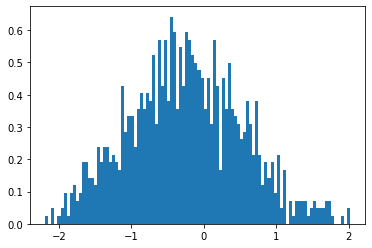

KeyboardInterrupt: ignored

In [ ]:
#for general use: code that does n runs of the gibbs process and returns the mse/kol values!
def avg_n(n, init_data, b, diffusion, Cls):
  trials = n
  mse = np.zeros(trials)
  kol = np.zeros(trials)
  for i in range(trials):
    print(f'run {i}')
    sde_obj = Cls(init_data, b, diffusion)
    sde_obj.run_gibbs(verbose = False)
    sde_obj.find_mse()
    sde_obj.find_kolmogorov()
    mse[i] = sde_obj.return_mse()
    kol[i] = sde_obj.return_kolmogorov()
  #plotting the shrinkage graph for the last of the ten runs
  sde_obj.plot_shrinkage()
  return mse, kol

def run_all_processes(params):
    results = {}
    grid = [(func_name, init_data, b, diffusion, Cls) for func_name, init_data, b, diffusion in params for Cls in [Gig, Ig, Shoe]]
    for func_name, init_data, b, diffusion, Cls in grid:
        print(f'with b = {func_name} and Cls = {Cls}...')
        #need to write mse and kolmo values to some dataframe (dict for now) to view it
        mse, kol = avg_n(5, init_data, b, diffusion, Cls)
        if Cls == Ig: id = func_name + '; Ig'
        elif Cls == Gig: id = func_name + '; Gig'
        elif Cls == Shoe: id = func_name + '; Shoe'
        results[id] = mse, kol
    return results

#quick wrapper for generating data and showing histogram
def gen_data_and_hist(b, diff):
    init_data = create_data(diff, b, 0.05, 50, 0)
    plt.hist(init_data, bins = 100, density = True)
    plt.show()
    return init_data
#function for making the list of params to run through the run_all_processes function
#basically, for each b, find a diffusion coefficient and data set that looks good and add them to the list
#input is a 2d array (nx2) where each entry is [b,diffusion] (there are n number of b functions we are looking at)
def make_params(b_diff_list):
    params = []
    for func_name, b, diff in b_diff_list:
        init_data = gen_data_and_hist(b, diff)
        while True:
            s = input('Enter "y" to use this data, "n" to make data again with this diffusion, \nor a number from 0.1 - 1.5 to make new data with diff = num: ')
            if s == 'y':
                break
            elif s == 'n':
                init_data = gen_data_and_hist(b, diff)
            elif float(s) <= 1.5 and float(s) >= 0.1:
                diff = float(s)
                init_data = gen_data_and_hist(b, diff)
        params.append([func_name, init_data, b, diff])
    return params

b_diff_list = [['b = -x', lambda x: -x, 1],
               ['b = 4*(x-x**3)', lambda x: 4*(x-x**3), 0.8],
               ['b = -(x**3)/(1+x**2)', lambda x: -(x**3)/(1+x**2), 0.2],
               ['b = -x*(1 + 0.5*np.sin(x))', lambda x: -x*(1 + 0.5*np.sin(x)), 0.2],
               ['b = 4*(1-x*(np.sin(x)**2 + 0.1))', lambda x: 4*(1-x*(np.sin(x)**2 + 0.1)), 0.5]]

params = make_params(b_diff_list)
results = run_all_processes(params)

In [ ]:
# for k, v in results.items():
#     print(k + ': \nAvg MSE was ', np.mean(v[0]), ' \nAvg kolmogorov err was ', np.mean(v[1]), '\n')

mse = np.array([np.mean(v[0]) for v in results.values()])
kolmo = np.array([np.mean(v[1]) for v in results.values()])

# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(16, 8))
 
# Set position of bar on X axis
centers = np.arange(len(mse)/2)
br1 = [x - barWidth/2 for x in centers]
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# print(mse[::2], '\n', mse[1::2], '\n', kolmo[::2],'\n', kolmo[1::2])

# Make the plot
plt.bar(br1, mse[::2], color ='g', width = barWidth,
        edgecolor ='white', label ='Lasso MSE')
plt.bar(br2, kolmo[::2], color ='b', width = barWidth,
        edgecolor ='white', label ='Lasso Kolmogorov')
plt.bar(br3, mse[1::2], color ='g', width = barWidth,
        edgecolor ='white', label ='T-Prior MSE', hatch = 'X')
plt.bar(br4, kolmo[1::2], color ='b', width = barWidth,
        edgecolor ='white', label ='T-prior Kolmogorov', hatch = 'X')
 
# Adding Xticks
plt.xlabel('Function b(x)', fontweight ='bold', fontsize = 15)
plt.ylabel('Error Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + 0.2 for r in range(int(len(mse)/2))],
        [i[0] for i in b_diff_list])
 
plt.legend()
plt.show()
# with open('restulsOct7.npy', 'wb') as f:
#     np.save(f, results) 

NameError: ignored

[0.25722222 0.16544444 0.15666667 0.21       0.16077778 0.38877778
 0.359      0.38655556 0.37088889 0.11144444 0.08577778 0.11144444
 0.06766667 0.04266667 0.05066667] (15,)


ValueError: ignored

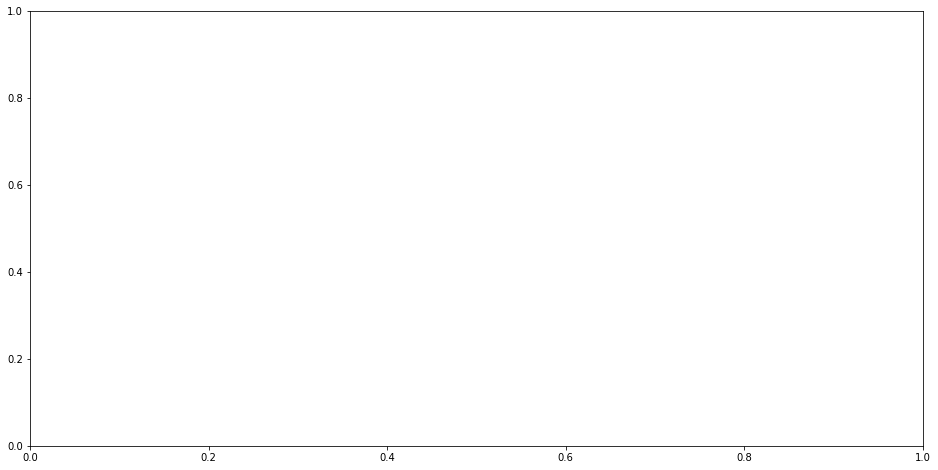

In [ ]:
# mse = np.array([np.mean(v[0]) for v in results.values()])
kolmo = np.array([np.mean(v[1]) for v in results.values()])
print(kolmo, kolmo.shape)
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(16, 8))
 
# Set position of bar on X axis
centers = np.arange(len(mse)/2)
br1 = [x - barWidth/2 for x in centers]
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# print(mse[::2], '\n', mse[1::2], '\n', kolmo[::2],'\n', kolmo[1::2])

# Make the plot
plt.bar(br1, kolmo[::3], color ='b', width = barWidth,
        edgecolor ='white', label ='Lasso Kolmogorov')
plt.bar(br2, kolmo[1::3], color ='g', width = barWidth,
        edgecolor ='white', label ='T-prior Kolmogorov')
plt.bar(br3, kolmo[2::3], color ='p', width = barWidth,
        edgecolor ='white', label ='Horshoe Kolmogorov')
 
# Adding Xticks
plt.xlabel('Function b(x)', fontweight ='bold', fontsize = 15)
plt.ylabel('Error Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + 0.2 for r in range(int(len(mse)/2))],
        [i[0] for i in b_diff_list])
 
plt.legend()
plt.show()

In [ ]:
np.save('my_file.npy', results) 

In [ ]:
#running for b(x) = sin(x)
t_end = 50
  
# diffusion = 1.
# def b(val): return np.sin(val)
# init_data = check_start_data(b, diffusion, t_end)

# gig_sin = Gig(init_data, b, diffusion)
# do_calcs_and_save_errors(gig_sin, 'GIG_sin')
# ig_sin = Ig(init_data, b, diffusion)
# do_calcs_and_save_errors(ig_sin, 'T-prior_sin')

In [ ]:
#running for b(x) = 4(x-x^3)
t_end = 50
  
# diffusion = 0.8
# def b(val): return 4*(val-val**3)
# init_data = check_start_data(b, diffusion, t_end)

# gig_sin = Gig(init_data, b, diffusion)
# do_calcs_and_save_errors(gig_sin, 'GIG_sin')
# ig_sin = Ig(init_data, b, diffusion)
# do_calcs_and_save_errors(ig_sin, 'T-prior_sin')

In [ ]:
#@title Double Well data setup
#Setting up the data for the double well (run the cells below once you generate data you are happy with)

t_end = 50

diffusion = 0.75
def b(val): return 3*val*(1-val**2)
init_data = check_start_data(b, diffusion, t_end)

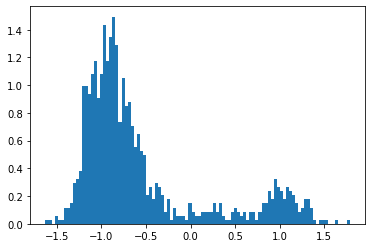

Are you happy with the way this data looks? [y/n]
n


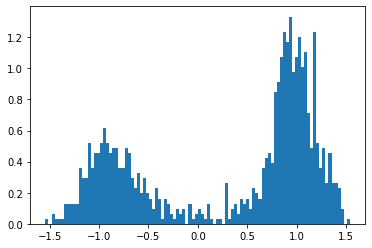

Are you happy with the way this data looks? [y/n] 
n


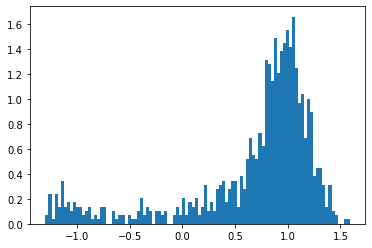

Are you happy with the way this data looks? [y/n] 
n


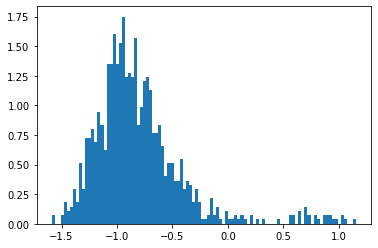

Are you happy with the way this data looks? [y/n] 
n


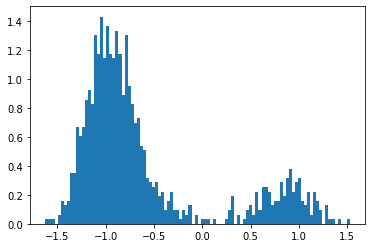

Are you happy with the way this data looks? [y/n] 
n


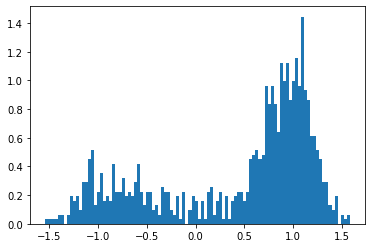

Are you happy with the way this data looks? [y/n] 
n


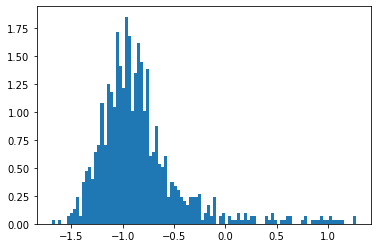

Are you happy with the way this data looks? [y/n] 
n


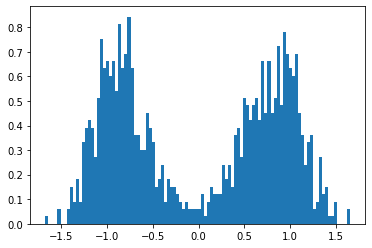

Are you happy with the way this data looks? [y/n] 
y
Do you want to run the gibbs process for GIG_doubleWell? [y/n] 
y
step 0 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: RuntimeWarning: covariance is not positive-semidefinite.


step 25 completed
step 50 completed
step 75 completed
step 100 completed
step 125 completed


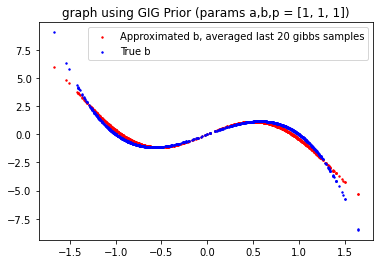

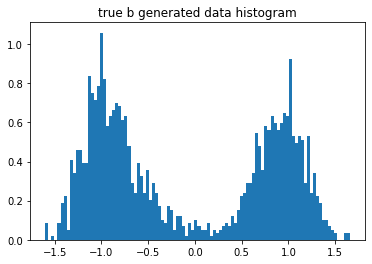

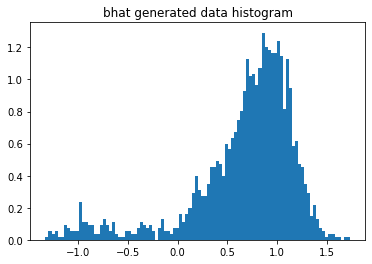

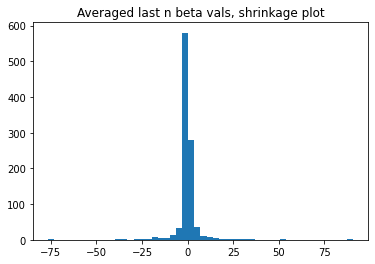

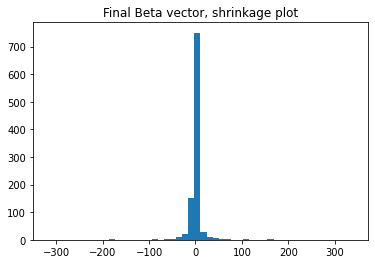

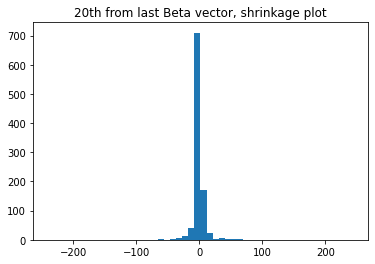

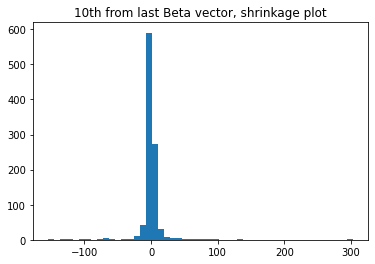

MSE for GIG_doubleWell = 0.10994433776473972.
Kolmogorov Error for GIG_doubleWell = 0.4605555555555555
Do you want to run the gibbs process for T-prior_doubleWell? [y/n] 
n


Exception: ignored

In [ ]:
#@title Double Well Gibbs Process + Graphing
gig_dw = Gig(init_data, b, diffusion)
do_calcs_and_save_errors(gig_dw, 'GIG_doubleWell')
ig_dw = Ig(init_data, b, diffusion)
do_calcs_and_save_errors(ig_dw, 'T-prior_doubleWell')

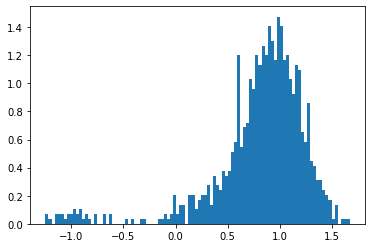

Are you happy with the way this data looks? [y/n]
n


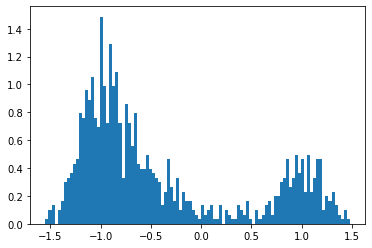

Are you happy with the way this data looks? [y/n] 
y
Do you want to run the gibbs process for Shoe_well? [y/n] 
y


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:671: RuntimeWarning: covariance is not positive-semidefinite.


step 0 completed
step 25 completed
step 50 completed
step 75 completed
step 100 completed
step 125 completed


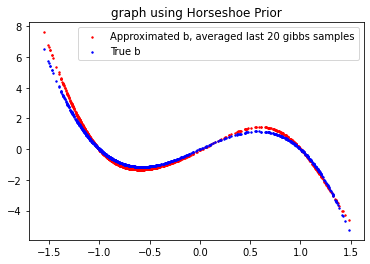

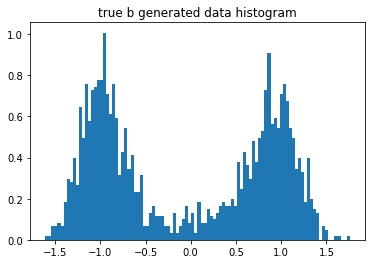

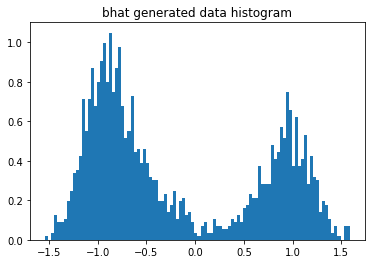

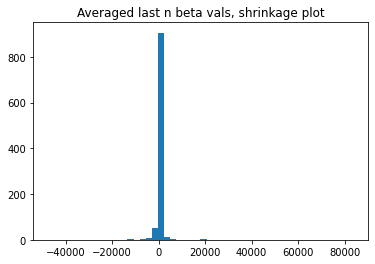

MSE for Shoe_well = 0.05946837561508175.
Kolmogorov Error for Shoe_well = 0.125


In [ ]:
diffusion = 0.8
def b(val): return 3*val*(1-val**2)
t_end = 50
init_data = check_start_data(b, diffusion, t_end)

shoe_well = Shoe(init_data, b, diffusion)
do_calcs_and_save_errors(shoe_well, 'Shoe_well')